# PINN Heat — Tuner Notebook 

This notebook **imports your package code** from `src/` (no class definitions here)
and allows to configure hyperparameters, run **4 variants**, plot losses, and evaluate metrics.

**Variants**:
1. `base` — no normalization, no nondimensionalization  
2. `norm_in` — input normalization only  
3. `nondim` — nondimensionalized PDE/BC + input normalization in star-space  
4. `full` — nondim + input norm + **adaptive loss weights**

In [ ]:
import sys
from pathlib import Path

# Agregar el directorio raíz del proyecto al Python path
project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

import copy
import os, json, time, random
import numpy as np
import pandas as pd
import torch

# --- App/library imports from codebase ---
from src.app.factory import build_model                    
from src.app.etl import load_df, prepare_tensors           
from src.app.train.loops import train_adam, train_lbfgs       
from src.app.evaluate import evaluate_model                
from src.app.infer.grids import predict_on_grid            
from src.app.viz.plots import plot_loss_history, plot_temperature_maps 
from src.app.pinn_heat.data import build_data_from_df as _build_data_from_df


In [2]:

# Reproducibility & device
SEED = 1234
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Configuración

In [ ]:
# Data        
TEMPERATURES_PATH = "../data/temperature.txt"   # .txt: [id, T_t0, T_t1, ..., T_tN]
POSITIONS_PATH   = "../data/mesh.csv"       # .csv: [id, x, y, z]
HAS_HEADER_POS   = False  # set to None if your CSV has no 'id' column

# Physics (SI)
physics = {
    "k": 50.0, "rho": 1200.0, "Cp": 100.0,
    "h": 750.0, "T_inf": 300.0,
    "qpp": 15000.0, "Ti": 300.0
}

# Domain
domain = {
    "Lx": 0.1, "Lz": 0.1,
    "x_left": -0.05, "x_right": 0.05,
    "z_bottom": 0.0, "z_top": 0.1
}

# Time
time_cfg = {
    "t_min": 0.0, "t_max": 60.0,
    "dt": 0.1, "N_time_use": 25  
}

# Data sampling sizes
data_cfg = {
    "N_data_nodes": 500,
    "N_f_interior": 10000,
    "N_b_per_face": 2000,
    "N_ic": 4000
}

# Network / training
train_cfg = {
    "nneurons": 32,             # Increased for better capacity
    "nlayers_hidden": 4,        # Reasonable depth
    "act": "tanh",              # tanh | relu | gelu
    "n_iter_adam": 1500,        # More iterations for better convergence
    "lr_adam": 1e-2,            # More reasonable learning rate
    "n_iter_lbfgs": 200,        # More LBFGS iterations
    "lr_lbfgs": 1e-5,           # Better LBFGS learning rate
}

# Static loss weights (ignored if adaptive=True)
loss_cfg = {
    "w_data": 1.0, "w_pde": 1.0, "w_bc": 1.0, "w_ic": 1.0,
    "adaptive": False  # set True for variant 'full', else base on variant below
}

# Variants to run
variants = ["base", "norm_in", "nondim", "full"]  # edit subset if desired

# Artifacts
out_root = "models/notebook_tuner"
os.makedirs(out_root, exist_ok=True)

alpha = physics["k"]/(physics["rho"]*physics["Cp"])
print("alpha =", alpha)

alpha = 0.0004166666666666667


In [4]:
def make_cfg_for_variant(variant: str) -> dict:
    """Create the config dict expected by app.factory.build_model for a given variant."""
    cfg = {
        "variant": variant,
        "data": {
            "temperature_path": TEMPERATURES_PATH,
            "mesh_path": POSITIONS_PATH,
            "has_header": HAS_HEADER_POS,
            "N_time_use": time_cfg["N_time_use"],
            "dt": time_cfg["dt"],
            "N_data_nodes": data_cfg["N_data_nodes"],
            "N_f_interior": data_cfg["N_f_interior"],
            "N_b_per_face": data_cfg["N_b_per_face"],
            "N_ic": data_cfg["N_ic"],
        },
        "physics": physics,
        "domain": domain,
        "time": time_cfg,
        "train": {
            "nneurons": train_cfg["nneurons"],
            "nlayers_hidden": train_cfg["nlayers_hidden"],
            "act": train_cfg["act"],
            "n_iter_adam": train_cfg["n_iter_adam"],
            "lr_adam": train_cfg["lr_adam"],
            "n_iter_lbfgs": train_cfg["n_iter_lbfgs"],
            "lr_lbfgs": train_cfg["lr_lbfgs"],
        },
        "loss": {
            "w_data": loss_cfg["w_data"],
            "w_pde": loss_cfg["w_pde"],
            "w_bc": loss_cfg["w_bc"],
            "w_ic": loss_cfg["w_ic"],
            "adaptive": (variant == "full") or bool(loss_cfg["adaptive"] and variant != "base")
        },
    }
    return cfg

## Leer datos

In [5]:
df = load_df(TEMPERATURES_PATH, POSITIONS_PATH, HAS_HEADER_POS)
print("DF shape:", df.shape)
display(df.head())

DF shape: (112211, 604)


,x,y,z,t0,t1,t2,t3,t4,t5,t6,...,t591,t592,t593,t594,t595,t596,t597,t598,t599,t600
id,,,,,,,,,,,,,,,,,,,,,
1,-0.05,-0.005,0.0,300,301.824,302.686,303.308,303.811,304.24,304.618,...,315.977,315.977,315.977,315.977,315.978,315.978,315.978,315.978,315.978,315.978
2,0.05,-0.005,0.0,300,301.824,302.686,303.308,303.811,304.24,304.618,...,315.977,315.977,315.977,315.977,315.978,315.978,315.978,315.978,315.978,315.978
3,0.05,0.005,0.0,300,301.824,302.686,303.308,303.811,304.24,304.618,...,315.977,315.977,315.977,315.977,315.978,315.978,315.978,315.978,315.978,315.978
4,-0.05,0.005,0.0,300,301.824,302.686,303.308,303.811,304.24,304.618,...,315.977,315.977,315.977,315.977,315.978,315.978,315.978,315.978,315.978,315.978
5,-0.05,-0.005,0.1,300,300.000,300.000,300.000,300.000,300.00,300.000,...,303.317,303.317,303.317,303.317,303.317,303.317,303.317,303.317,303.317,303.317


[ADAM] epoch=  2000 total=-8.2999e+00
[ADAM] done in 145.6s


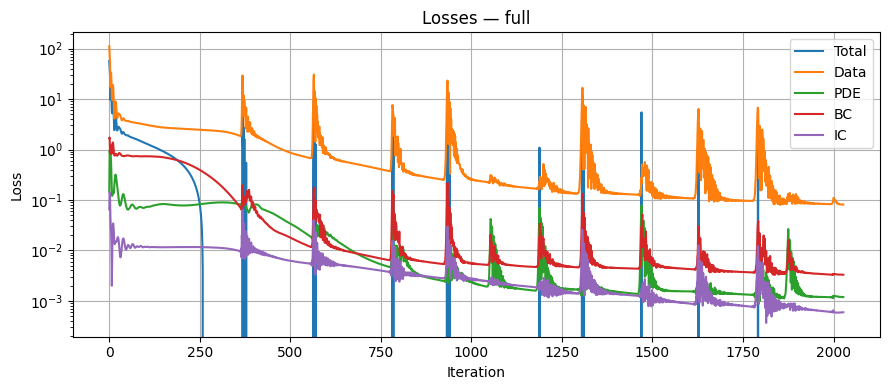

[full] MAE=2.1671e-01 | RMSE=2.7810e-01 | N=25000


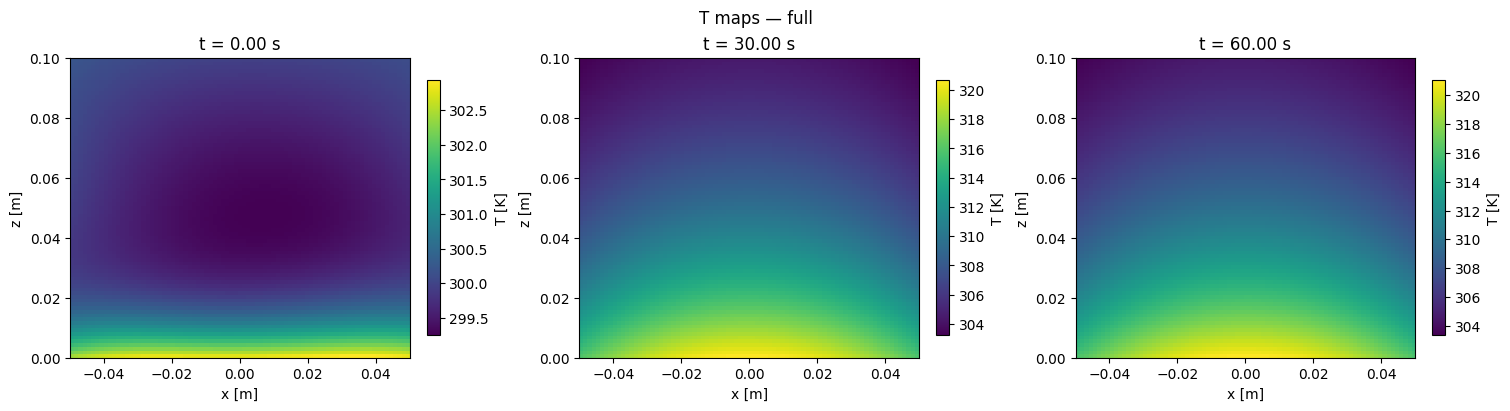

In [ ]:
all_runs = {
    "histories": {},
    "metrics": {},
    "maps": {},
    "timings": {},   # <- NUEVO: tiempos por variante
}

results = {}

NO_CLEAR = 10**12  # evita clear_output en loops

for variant in variants:
    print("\n" + "="*90)
    print(f"Variant: {variant}")
    print("="*90)

    t_variant0 = time.time()

    # --- Build model & configs
    t0 = time.time()
    cfg = make_cfg_for_variant(variant)
    model, (phys, dom, timec, trainc), device_used = build_model(cfg)
    t_build = time.time() - t0

    # --- Prepare tensors (en unidades físicas)
    t0 = time.time()
    X_data, T_data, X_f, BCs, X_ic = prepare_tensors(
        df, cfg_data=cfg["data"], cfg_time=cfg["time"], cfg_domain=cfg["domain"], device=device_used
    )
    t_prep = time.time() - t0

    # --- Train (ADAM)
    t0 = time.time()
    train_adam(
        model, X_data, T_data, X_f, BCs, X_ic,
        n_iter=trainc.n_iter_adam,
        lr=trainc.lr_adam,
        show_every=NO_CLEAR,
    )
    t_adam = time.time() - t0

    # --- Train (LBFGS)
    t0 = time.time()
    train_lbfgs(
        model, X_data, T_data, X_f, BCs, X_ic,
        n_iter=trainc.n_iter_lbfgs,
        lr=trainc.lr_lbfgs,
        show_every=NO_CLEAR,
    )
    t_lbfgs = time.time() - t0

    # --- Evaluación simple (bypass IO)
    t0 = time.time()
    X_eval, T_eval = _build_data_from_df(
        df, cfg["data"]["N_data_nodes"], cfg["time"]["N_time_use"], cfg["time"]["dt"], device_used
    )
    with torch.no_grad():
        u_pred = model(X_eval)
        T_pred = model.nondim.state_to_T(u_pred)
    y_true = T_eval.cpu().numpy().ravel()
    y_pred = T_pred.cpu().numpy().ravel()
    mae = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))
    t_eval = time.time() - t0
    print(f"[{variant}] MAE={mae:.4e} | RMSE={rmse:.4e} | N={len(y_true)}")

    # --- Inference maps + guardado de figuras
    t0 = time.time()
    t0s, tMs, tFs = timec.t_min, 0.5*(timec.t_min + timec.t_max), timec.t_max
    T_maps, xs, zs = predict_on_grid(
        model, dom.x_left, dom.x_right, dom.z_bottom, dom.z_top,
        [t0s, tMs, tFs], nx=81, nz=81, device=device_used
    )
    maps_time = time.time() - t0

    # --- Guardar artefactos
    out_dir = os.path.join(out_root, variant)
    os.makedirs(out_dir, exist_ok=True)

    # modelo e historial
    torch.save(model.state_dict(), os.path.join(out_dir, "model.pt"))
    with open(os.path.join(out_dir, "history.json"), "w") as f:
        json.dump(model.history, f, indent=2)

    # plots
    plot_loss_history(model.history, path=os.path.join(out_dir, "losses.png"),
                      title=f"Losses — {variant}")
    plot_temperature_maps(T_maps, xs, zs, path=os.path.join(out_dir, "maps_t0_tM_tF.png"),
                          title=f"T maps — {variant}")

    # grillas
    np.savez_compressed(
        os.path.join(out_dir, "maps_t0_tM_tF.npz"),
        xs=xs, zs=zs,
        **{f"t_{t:.6f}": T_maps[float(t)] for t in [t0s, tMs, tFs]}
    )

    # --- Tiempos y métricas
    t_total = time.time() - t_variant0
    timings = {
        "build_s": t_build,
        "prepare_s": t_prep,
        "adam_s": t_adam,
        "lbfgs_s": t_lbfgs,
        "eval_s": t_eval,
        "maps_s": maps_time,
        "total_s": t_total,
    }

    metrics_payload = {"mae": mae, "rmse": rmse, "N": len(y_true), "timings": timings}
    with open(os.path.join(out_dir, "metrics.json"), "w") as f:
        json.dump(metrics_payload, f, indent=2)
    with open(os.path.join(out_dir, "timings.json"), "w") as f:
        json.dump(timings, f, indent=2)

    # --- Conservar en memoria
    all_runs["histories"][variant] = {k: v[:] for k, v in model.history.items()}
    all_runs["metrics"][variant] = {"mae": mae, "rmse": rmse, "N": len(y_true)}
    all_runs["timings"][variant] = timings
    all_runs["maps"][variant] = {
        "times": [float(t0s), float(tMs), float(tFs)],
        "xs": xs.copy(),
        "zs": zs.copy(),
        # "T_maps": {float(k): v.copy() for k, v in T_maps.items()}  # descomentar si querés guardarlo en RAM
    }

    results[variant] = {"mae": mae, "rmse": rmse, "N": len(y_true), **timings}

# Resumen final con tiempos
summary = pd.DataFrame([
    {"variant": v, **m} for v, m in results.items()
]).sort_values("rmse")
display(summary)
print(f"Artefactos guardados en: {out_root}")


In [7]:
summary = pd.DataFrame([{"variant": v, **m} for v, m in results.items()]).sort_values("rmse")
summary

,variant,mae,rmse,N
2,nondim,0.057004,0.117387,25000
3,full,0.216710,0.278103,25000
0,base,2.737450,4.087424,25000
1,norm_in,2.757015,4.114915,25000


## Data efficiency (Variant `full`)

Entrenamos la variante **full** con diferentes cantidades de puntos de datos conocidos y comparamos el desempeño (MAE/RMSE):
- 5,000
- 1,000
- 500
- 100

In [ ]:
sizes = [5000, 1000, 500, 100]
data_eff_results = []

for Nnodes in sizes:
    print("\\n" + "="*90)
    print(f"[FULL] Data nodes: {Nnodes}")
    print("="*90)

    # Build a config for the full variant
    cfg = make_cfg_for_variant("full")
    cfg["data"]["N_data_nodes"] = Nnodes

    # Build model
    model, (phys, dom, timec, trainc), device_used = build_model(cfg)

    # Prepare tensors
    df_local = df  # reuse loaded df
    X_data, T_data, X_f, BCs, X_ic = prepare_tensors(
        df_local, cfg_data=cfg["data"], cfg_time=cfg["time"], cfg_domain=cfg["domain"], device=device_used
    )

    # Train
    train_adam(model, X_data, T_data, X_f, BCs, X_ic,
               n_iter=trainc.n_iter_adam, lr=trainc.lr_adam, show_every=max(100, trainc.n_iter_adam//50))
    train_lbfgs(model, X_data, T_data, X_f, BCs, X_ic,
                n_iter=trainc.n_iter_lbfgs, lr=trainc.lr_lbfgs, show_every=20)

    # Evaluate (holdout-style over a fresh sample drawn from df)
    from pinn_heat.data import build_data_from_df as _build_data_from_df
    X_eval, T_eval = _build_data_from_df(df_local, Nnodes, cfg["time"]["N_time_use"], cfg["time"]["dt"], device_used)
    with torch.no_grad():
        u_pred = model(X_eval)
        T_pred = model.nondim.state_to_T(u_pred)
    y_true = T_eval.cpu().numpy().ravel()
    y_pred = T_pred.cpu().numpy().ravel()
    mae = float(np.mean(np.abs(y_pred - y_true)))
    rmse = float(np.sqrt(np.mean((y_pred - y_true)**2)))

    print(f"[FULL | N={Nnodes}] MAE={mae:.4e} | RMSE={rmse:.4e} | Points={len(y_true)}")
    plot_loss_history(model.history, path=None, title=f"Losses — FULL (N={Nnodes})")

    data_eff_results.append({"N_data_nodes": Nnodes, "mae": mae, "rmse": rmse})

# Summary table
import pandas as pd
df_data_eff = pd.DataFrame(data_eff_results).sort_values("N_data_nodes", ascending=False)
df_data_eff